In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from pandas import read_excel
from scipy.optimize import curve_fit
import math
from statistics import mean
import copy as copy

Importação de dados

In [49]:
df = pd.read_excel('Planilha do raio-x.xlsx', sheet_name='Dados', header=None, names=['A', 'B', 'C', 'D','E', 'F'])
df = df.replace({',': '.'}, regex=True)
hs = pd.read_excel('Planilha do raio-x.xlsx', sheet_name='Hist', header=None, names=['A', 'B'])
tm = pd.read_excel('Planilha do raio-x.xlsx', sheet_name='TMorto', header=None, names=['A', 'B'])
tm = tm.replace({',':'.'}, regex=True)
print(hs)
# Incerteza pro angulo == 0.005 Graus, metade da menor divisão 

         A     B
0    101.4  1014
1    101.2  1012
2     99.6   996
3     97.1   971
4     98.1   981
..     ...   ...
96    92.2   922
97    95.0   950
98    95.3   953
99    91.4   914
100   91.4   914

[101 rows x 2 columns]


Histograma

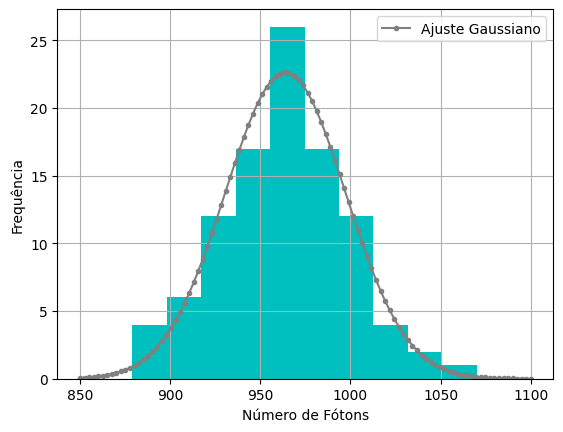

[  33.41569176  963.90707482 1894.63185607] 
 [[ 5.83138810e+00 -2.74631569e-02  1.65607015e+02]
 [-2.74631569e-02  5.76292027e+00 -8.81977435e-01]
 [ 1.65607015e+02 -8.81977435e-01  1.39498647e+04]]
33.41569175961235
31.028571949539067


In [50]:
def gaussB(x, a, b, N):
    return N*(1/(a*(2*math.pi)**(1/2)))*np.exp((-(x-b)**2/(2*a**2)))

Nbins = int(math.sqrt(median(hs['B']))/3)



ListaOrdHist = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
LarguraBarra = (max(hs['B']) - min(hs['B']))/10
ListaAbsHist = []

for i in range(10):
    for j in range(len(hs['B'])):
        if min(hs['B']) + i*LarguraBarra  <= hs['B'][j] <= min(hs['B']) + (i+1)*LarguraBarra:
            ListaOrdHist[i] = ListaOrdHist[i] + 1
    ListaAbsHist = ListaAbsHist + [min(hs['B']) + LarguraBarra*i + LarguraBarra/2]


poptHist, pcovHist = curve_fit(gaussB, ListaAbsHist, ListaOrdHist, bounds=([10, 930, 0], [60, 1000, 5000])) #a, b, N

rgBL2 = np.linspace(850, 1100, 100)


plt.hist(hs['B'], bins=Nbins, color='c')
plt.plot(rgBL2, gaussB(rgBL2, *poptHist), marker = '.', color = 'Gray', label='Ajuste Gaussiano')
plt.legend()
plt.xlabel('Número de Fótons')
plt.ylabel('Frequência')
plt.grid()
plt.show()

print(poptHist,'\n', pcovHist)

SigmaHist = poptHist[0]
print(SigmaHist)
print(mean(hs['B'])**(1/2))


Caracterização do tempo morto 

Parâmetro a: 2777.563298298777 
Incerteza Parâmetro a: 92.42545341720313 
Parâmetro b: 26.792354455752843 
Incerteza Parâmetro b: 17.169613601657556


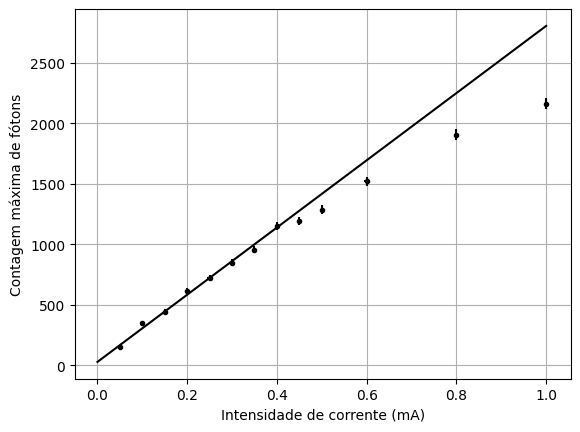

Parâmetro a: 0.0003388149522386391 
Incerteza Parâmetro a: 3.716546480435374e-06 
Parâmetro b (TEMPO MORTO): 2.2951543992473793e-05 
Incerteza Parâmetro b (TEMPO MORTO): 6.920137598145366e-06


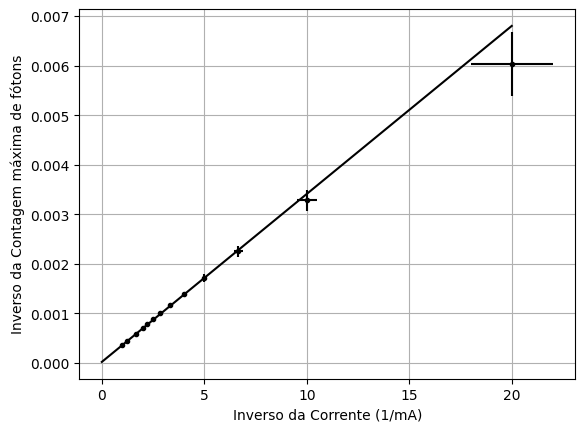

In [51]:
tm['C'] = np.sqrt(tm['B'])
tm['D'] = 0.005

def ajusteTempoMorto(x,a,b):
    return a*x + b

tmAjuste1 = tm.query('0 <= A <= 0.4')

poptTM, pcovTM = curve_fit(ajusteTempoMorto, tmAjuste1['A'], tmAjuste1['B'], sigma=tmAjuste1['C'])
print('Parâmetro a:', poptTM[0], '\nIncerteza Parâmetro a:', np.sqrt(pcovTM[0][0]) ,'\nParâmetro b:', poptTM[1], '\nIncerteza Parâmetro b:', np.sqrt(pcovTM[1][1]))

x1 = np.linspace(0,1,200)

plt.errorbar(tm['A'], tm['B'], tm['C'], tm['D'], '.k')
plt.plot(x1,ajusteTempoMorto(x1,poptTM[0],poptTM[1]), 'k')
plt.xlabel('Intensidade de corrente (mA)')
plt.ylabel('Contagem máxima de fótons')
plt.grid()
plt.show()

tm['E'] = 1/tm['A']
tm['F'] = 1/ajusteTempoMorto(tm['A'],poptTM[0],poptTM[1])
tm['G'] = tm['F']**2 * np.sqrt((tm['A'])**2 * pcovTM[0][0] + pcovTM[1][1])
tm['H'] = tm['E']**2 * tm['D']

poptTM2, pcovTM2 = curve_fit(ajusteTempoMorto, tm['E'], tm['F'], sigma=tm['G'])
print('Parâmetro a:', poptTM2[0], '\nIncerteza Parâmetro a:', np.sqrt(pcovTM2[0][0]) ,'\nParâmetro b (TEMPO MORTO):', poptTM2[1], '\nIncerteza Parâmetro b (TEMPO MORTO):', np.sqrt(pcovTM2[1][1]))

x2 = np.linspace(0,20,200)

plt.errorbar(tm['E'], tm['F'], tm['G'], tm['H'], '.k')
plt.plot(x2,ajusteTempoMorto(x2,poptTM2[0],poptTM2[1]), 'k')
plt.xlabel("Inverso da Corrente (1/mA)")
plt.ylabel("Inverso da Contagem máxima de fótons")
plt.grid()
plt.show()

df['B'] = df['B']/(1-(pcovTM2[1][1]*df['B']))
df['C'] = df['C']/(1-(pcovTM2[1][1]*df['C']))
df['D'] = df['D']/(1-(pcovTM2[1][1]*df['D']))
df['E'] = df['E']/(1-(pcovTM2[1][1]*df['E']))
df['F'] = df['F']/(1-(pcovTM2[1][1]*df['F']))

Plot 35KV, 30KV, 28KV, 25KV, 18KV

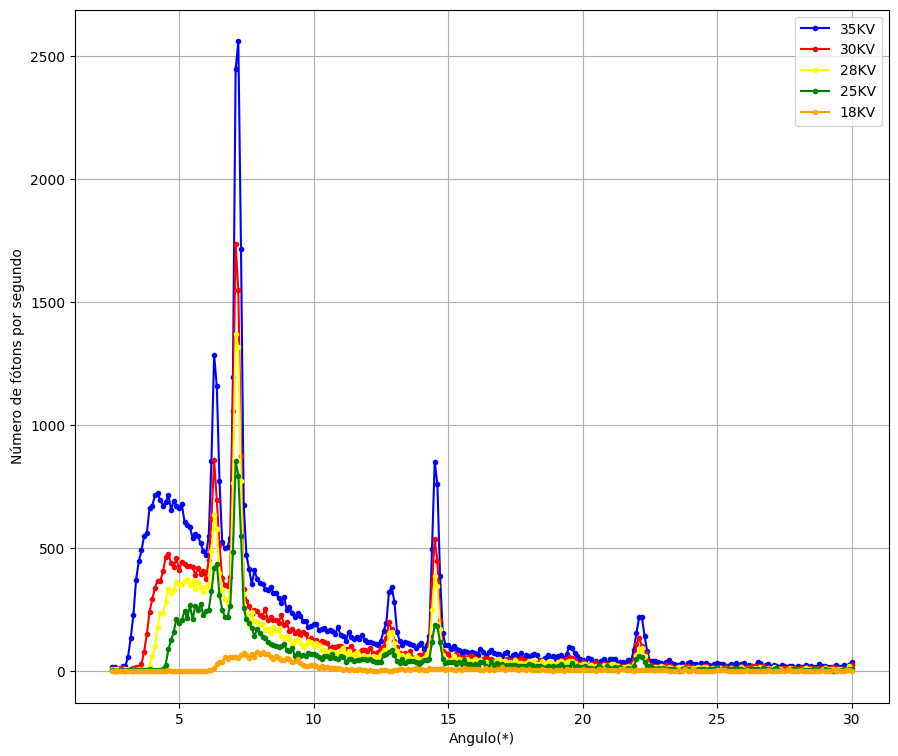

In [52]:
plt.figure(figsize=(10.5, 9))

plt.plot(df['A'], df['B'], label='35KV', marker='.', color='Blue')
plt.plot(df['A'], df['C'], label='30KV', marker='.', color='Red')
plt.plot(df['A'], df['D'], label='28KV', marker='.', color='Yellow')
plt.plot(df['A'], df['E'], label='25KV', marker='.', color='Green')
plt.plot(df['A'], df['F'], label='18KV', marker='.', color='Orange')
plt.xlabel('Angulo(*)')
plt.ylabel('Número de fótons por segundo')
plt.grid()
plt.legend()
plt.show()

Calculo de I_a / I_b == n_a / n_b pela hipótese de planck, e posterior análise de picos

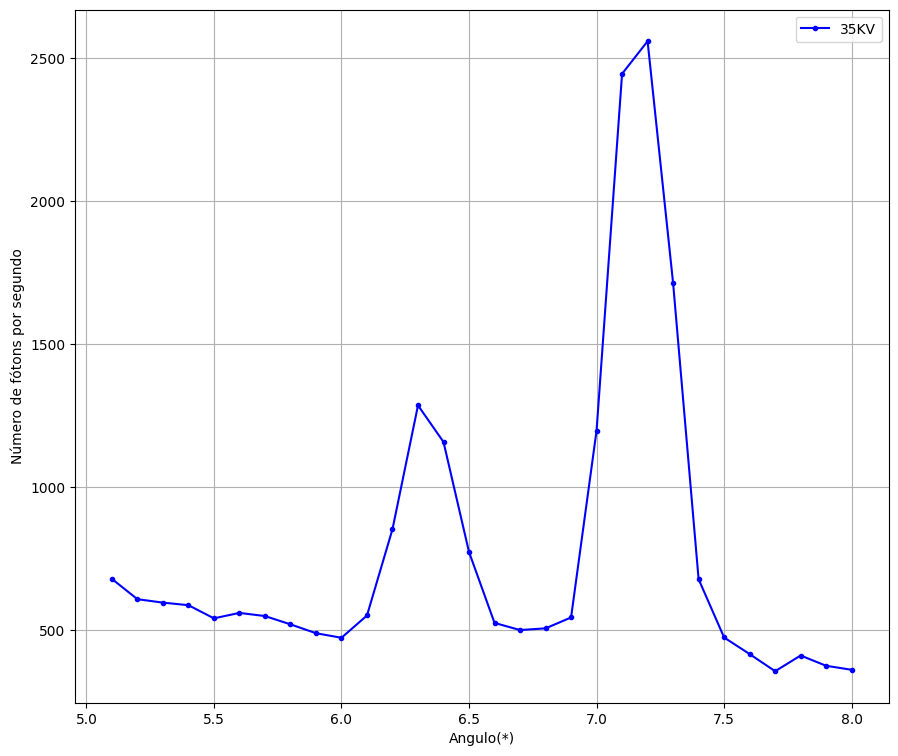

Para o pico alfa : 
 a =  0.015471113410033457 
 b =  7.169126801174828 
 N =  2393.243866103531 
 c =  299.99999999999994 
 Matriz de covariancia : 
 [[ 6.00425508e-06  5.87271142e-07 -8.12046077e-03 -1.97738322e-01]
 [ 5.87271142e-07  3.80934682e-05  1.65585018e-02 -3.04670765e-02]
 [-8.12046077e-03  1.65585018e-02  1.98371021e+04 -4.65598939e+03]
 [-1.97738322e-01 -3.04670765e-02 -4.65598939e+03  9.25601445e+03]] 
 Ajuste do pico alfa já considerando incertezas :


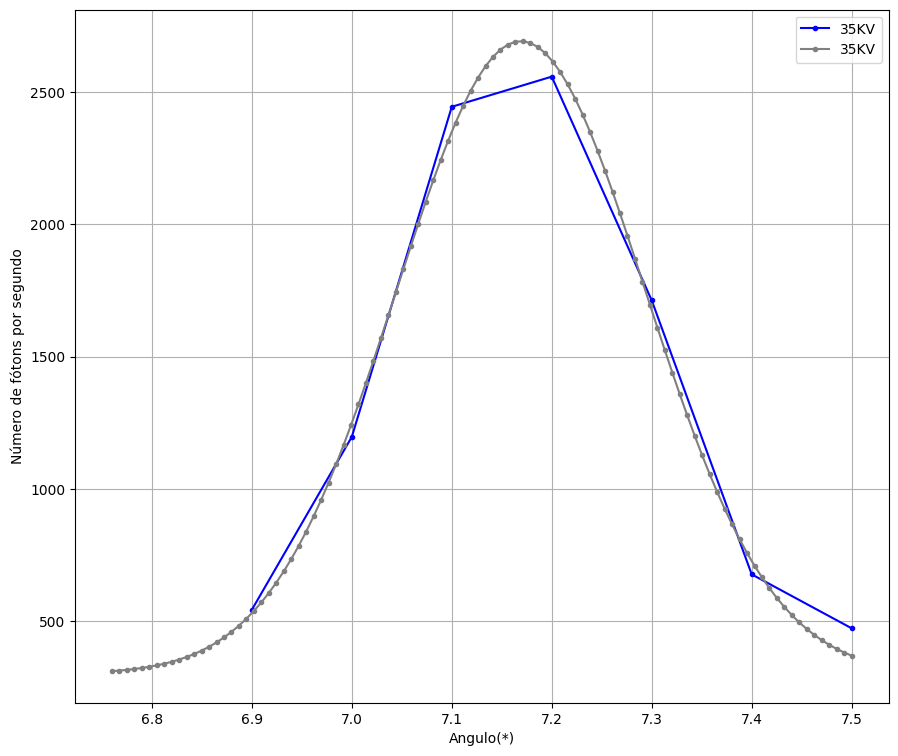

Para o pico Beta : 
 a =  0.023028771030112284 
 b =  6.336061950794112 
 N =  925.0748324240934 
 c =  299.99999999999994 
 Matriz de covariancia : 
 [[ 9.54064996e-05 -1.15502728e-05  7.76369814e-01 -1.31815666e+00]
 [-1.15502728e-05  1.69582505e-04 -1.98402189e-01  2.33075305e-01]
 [ 7.76369814e-01 -1.98402189e-01  1.90427852e+04 -1.61132219e+04]
 [-1.31815666e+00  2.33075305e-01 -1.61132219e+04  2.16235343e+04]] 
 Ajuste do pico beta já considerando incertezas :


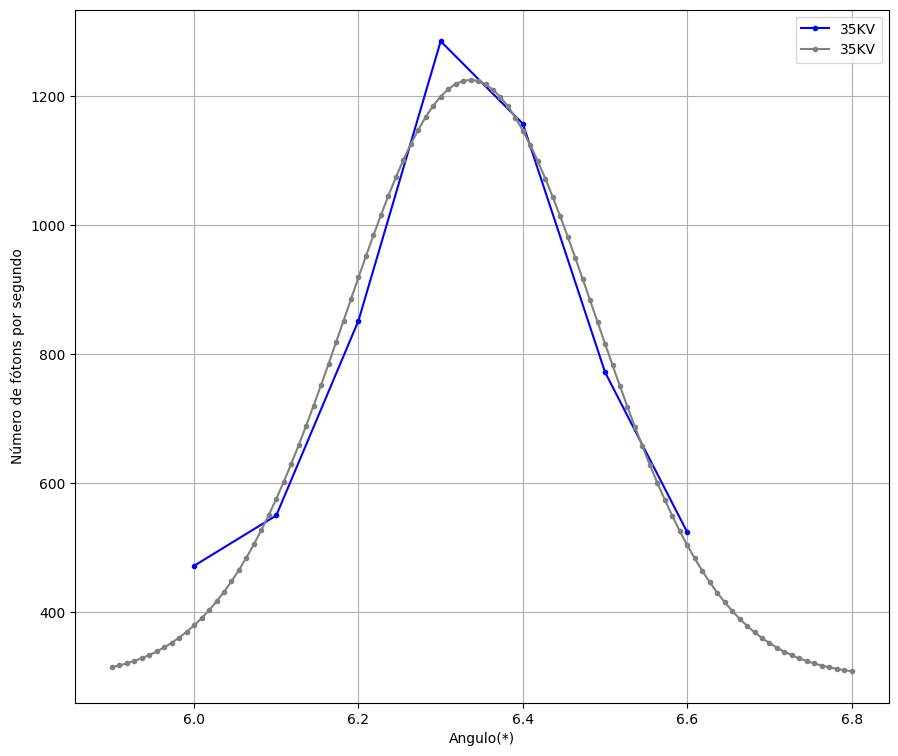

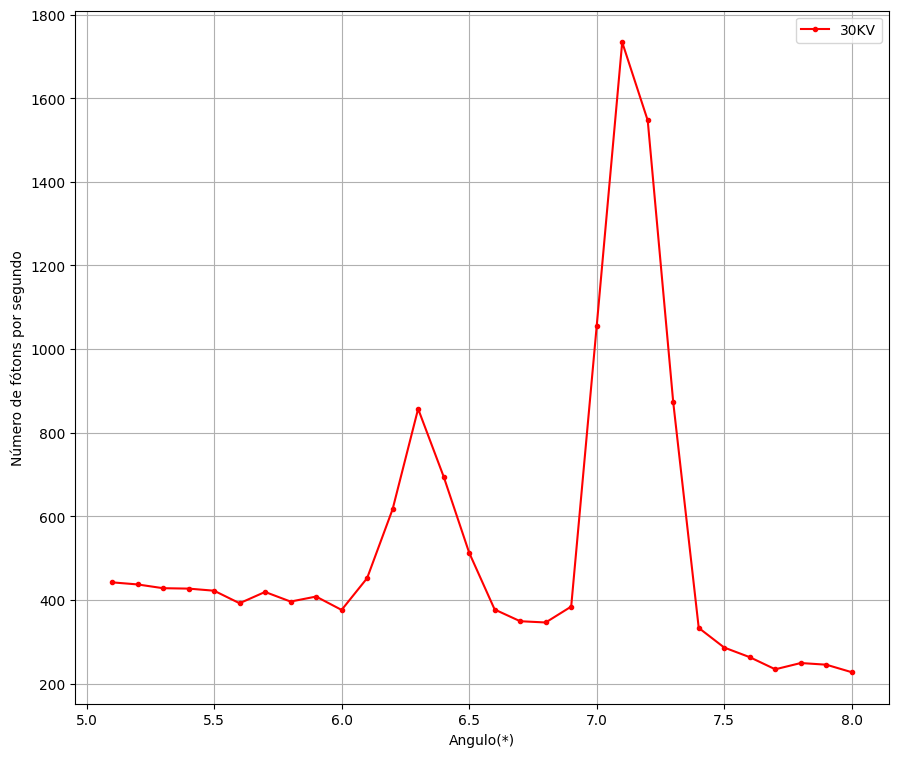

Para o pico alfa : 
 a =  0.01227987282811765 
 b =  7.137314129856239 
 N =  1549.729773648882 
 c =  278.03522533505014 
 Matriz de covariancia : 
 [[ 4.55266271e-06  1.16971053e-07 -4.41067900e-02 -9.40550539e-02]
 [ 1.16971053e-07  5.02661918e-05 -1.34421189e-02  3.91132374e-03]
 [-4.41067900e-02 -1.34421189e-02  1.16197240e+04 -1.36103639e+03]
 [-9.40550539e-02  3.91132374e-03 -1.36103639e+03  3.23093303e+03]] 
 Ajuste do pico alfa já considerando incertezas :


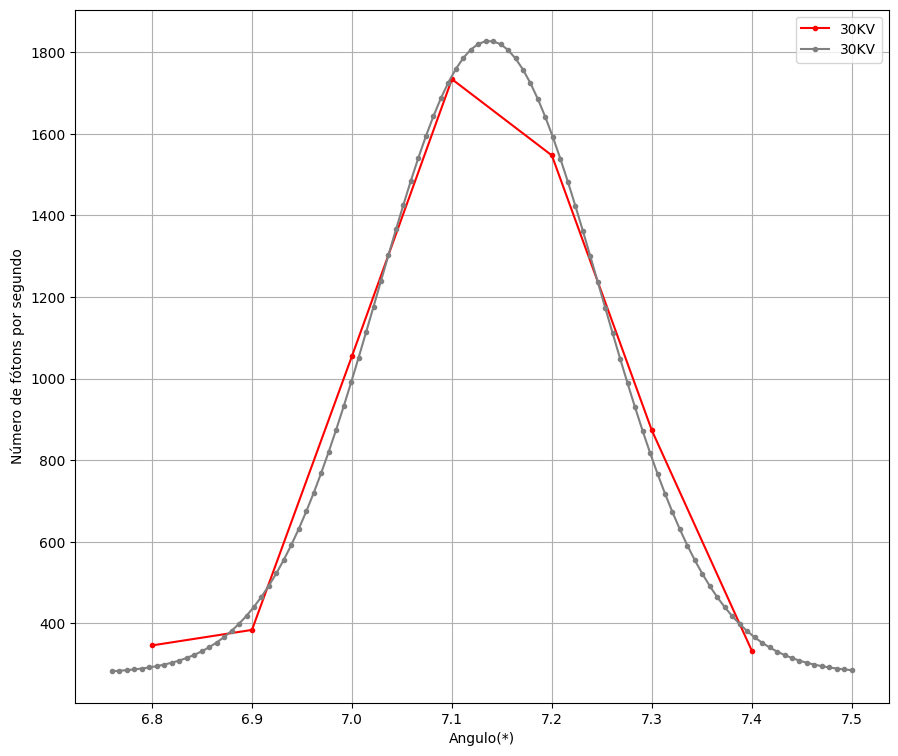

Para o pico Beta : 
 a =  0.020117042827111853 
 b =  6.316683429671019 
 N =  499.5391493872711 
 c =  299.99999999999994 
 Matriz de covariancia : 
 [[ 5.85988974e-05 -2.27988243e-06  2.55472827e-01 -4.64844948e-01]
 [-2.27988243e-06  1.29751127e-04 -2.12829146e-02  2.62668691e-02]
 [ 2.55472827e-01 -2.12829146e-02  3.94510908e+03 -3.19248199e+03]
 [-4.64844948e-01  2.62668691e-02 -3.19248199e+03  4.44036583e+03]] 
 Ajuste do pico beta já considerando incertezas :


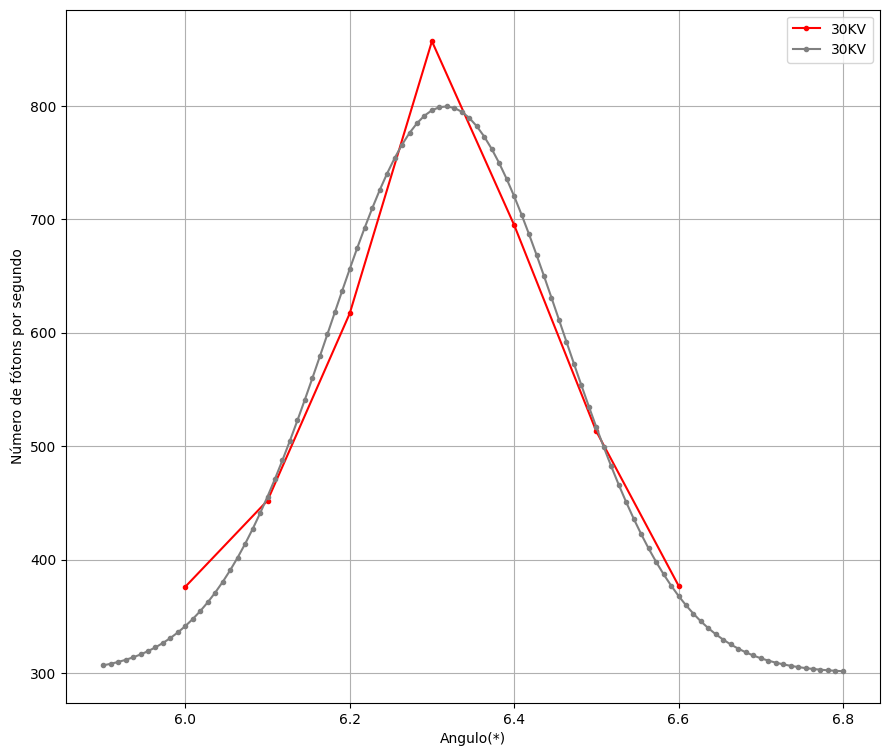

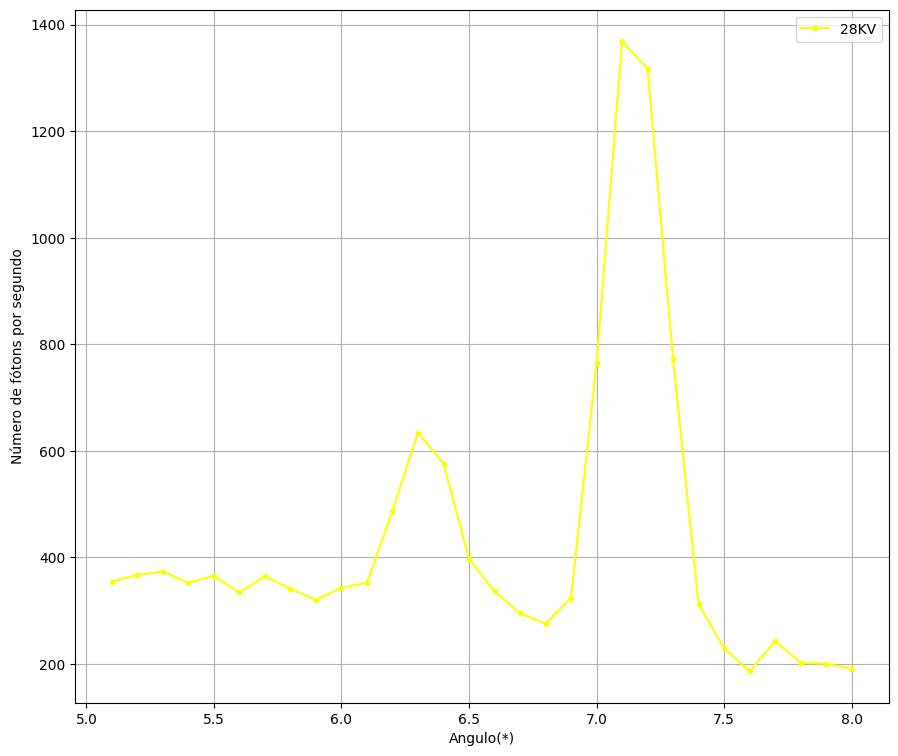

Para o pico alfa : 
 a =  0.012393398362414472 
 b =  7.148489949554861 
 N =  1234.3331782538703 
 c =  241.39994753056556 
 Matriz de covariancia : 
 [[ 1.73822436e-06 -5.82502642e-08 -1.44508166e-02 -2.78024336e-02]
 [-5.82502642e-08  1.98242327e-05 -2.82629890e-03  2.92228373e-03]
 [-1.44508166e-02 -2.82629890e-03  2.90129161e+03 -3.50124993e+02]
 [-2.78024336e-02  2.92228373e-03 -3.50124993e+02  7.78458211e+02]] 
 Ajuste do pico alfa já considerando incertezas :


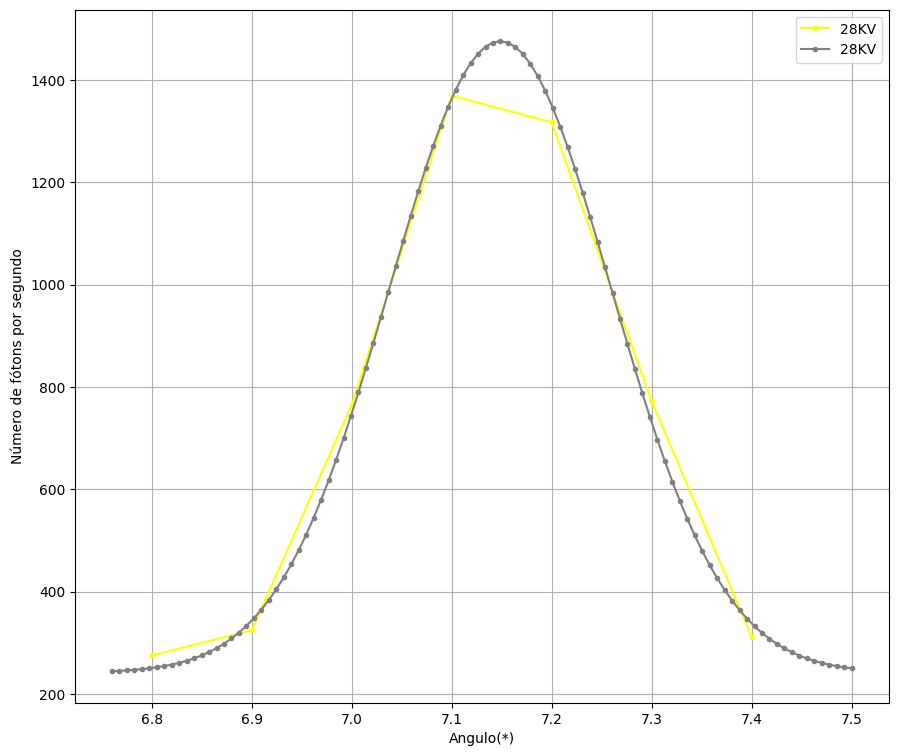

Para o pico Beta : 
 a =  0.013850128698196126 
 b =  6.32330291420545 
 N =  335.5757822726917 
 c =  299.99999999999994 
 Matriz de covariancia : 
 [[ 1.30535705e-05 -4.90794547e-07  1.40772989e-02 -7.17240213e-02]
 [-4.90794547e-07  8.83326375e-05 -1.90916186e-03  3.81236247e-03]
 [ 1.40772989e-02 -1.90916186e-03  9.35055430e+02 -3.91590565e+02]
 [-7.17240213e-02  3.81236247e-03 -3.91590565e+02  5.98488780e+02]] 
 Ajuste do pico beta já considerando incertezas :


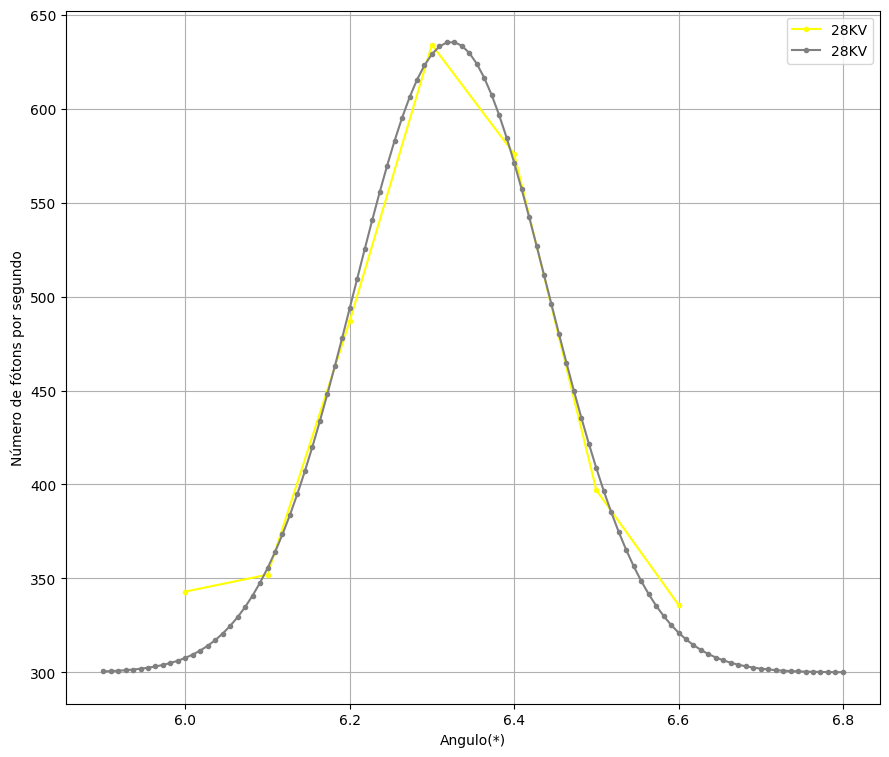

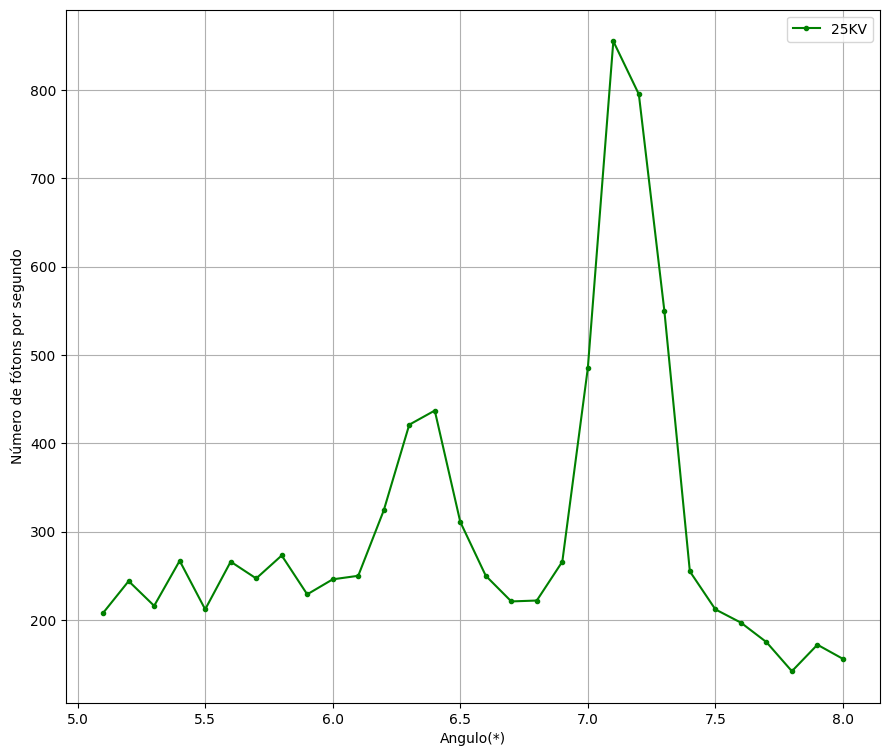

Para o pico alfa : 
 a =  0.01344087313747581 
 b =  7.15248020790977 
 N =  700.0000000000001 
 c =  201.13285527325218 
 Matriz de covariancia : 
 [[ 4.30664862e-06 -2.19084604e-08 -8.96201684e-03 -4.09475398e-02]
 [-2.19084604e-08  4.05667870e-05 -5.52001315e-03  3.71066300e-03]
 [-8.96201684e-03 -5.52001315e-03  1.77555795e+03 -3.60300813e+02]
 [-4.09475398e-02  3.71066300e-03 -3.60300813e+02  6.57071614e+02]] 
 Ajuste do pico alfa já considerando incertezas :


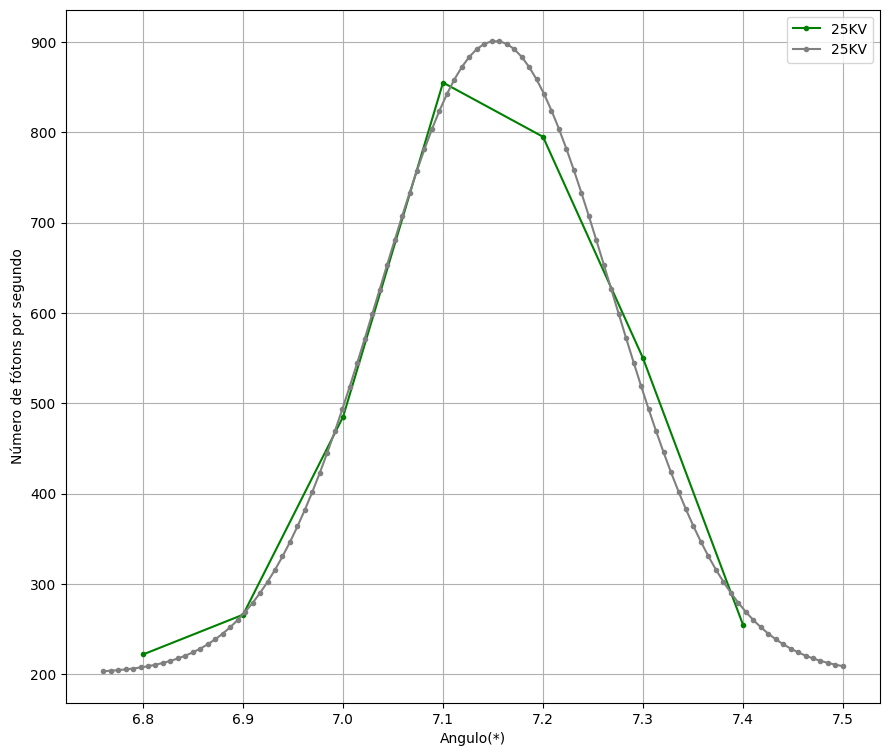

Para o pico Beta : 
 a =  0.036521637107949104 
 b =  6.355250346801619 
 N =  300.00000000000006 
 c =  126.51459981828752 
 Matriz de covariancia : 
 [[ 8.46592481e-04  1.04744718e-04  2.80536417e+00 -3.37129523e+00]
 [ 1.04744718e-04  3.60207799e-04  5.15768090e-01 -5.49694482e-01]
 [ 2.80536417e+00  5.15768090e-01  1.19703258e+04 -1.27176174e+04]
 [-3.37129523e+00 -5.49694482e-01 -1.27176174e+04  1.45109234e+04]] 
 Ajuste do pico beta já considerando incertezas :


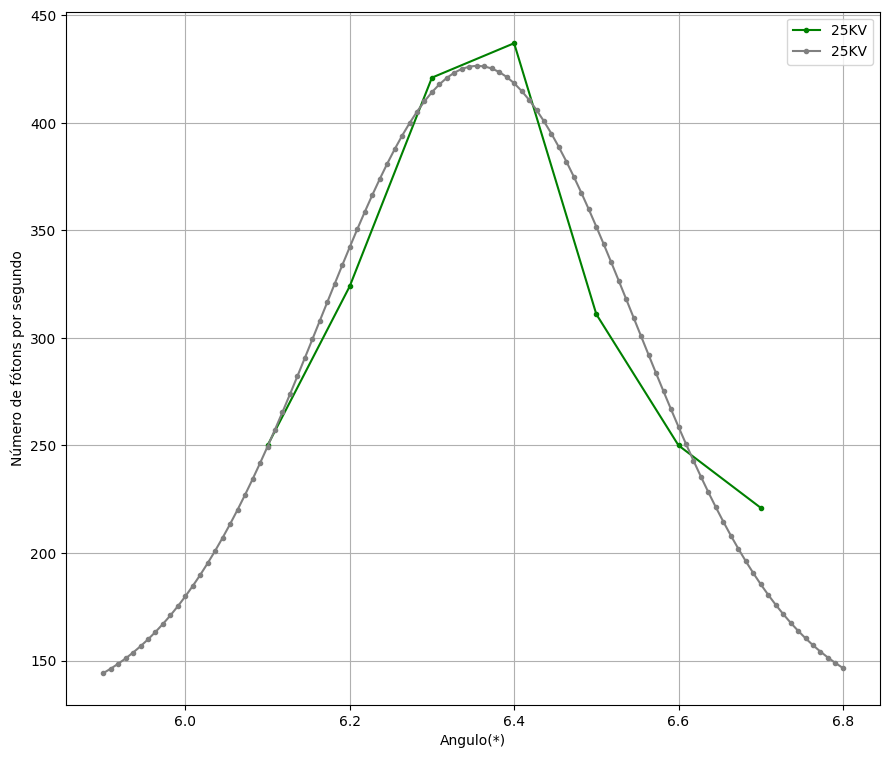

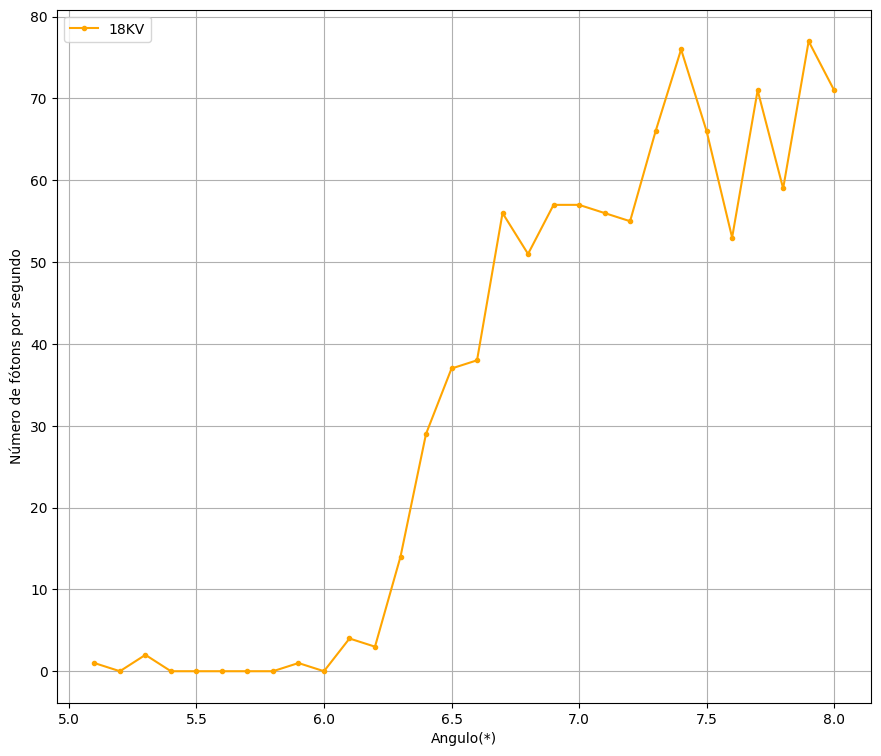

In [53]:
cores = ['Blue', 'Red', 'Yellow', 'Green', 'Orange']
voltagens =['35KV', '30KV', '28KV', '25KV', '18KV']
grafs = ['B', 'C', 'D', 'E', 'F']
def AnalisePicos(cor, voltagem, graf):
    selecANG =[]
    selecNF = []
    def gauss(x, a, b, N, c):
        return c + N*np.exp((-(x-b)**2/(2*a)))
    
    for i in range(0, 275):
        if df['A'][i] >= 5.01  and df['A'][i] <= 8 :
            selecANG.append(df['A'][i])
            selecNF.append(df[graf][i])
    
    

    plt.figure(figsize=(10.5, 9))
    plt.plot(selecANG, selecNF, label=voltagem, marker='.', color=cor )
    plt.xlabel('Angulo(*)')
    plt.ylabel('Número de fótons por segundo')
    plt.grid()
    plt.legend()
    plt.show()
    
    
    if cor != 'Orange':
        
        #calculo dos I_alfa e I_beta
        ListaOrdenadasPico1 = [] #lista das ordenadas dos pontos proximos ao pico 1
        ListaAbsPico1 = [] #lista das abissiças dos pontos proximos ao pico 1
        Npico1 = 0 #Posição (ou indice) das coordenadas do pico 1 nas lista selecANG e selecNF
        
        ListaOrdenadasPico2 = [] #lista das ordenadas dos pontos proximos ao pico 2
        ListaAbsPico2 = [] #lista das abissiças dos pontos proximos ao pico 2
        
        selecNFtiraPico1 = copy.deepcopy(selecNF)
        selecANGtiraPico1 = copy.deepcopy(selecANG)
        
        
        
        
        for i in range(len(selecNF)):
            if selecNF[i]==max(selecNF):
                Npico1 = i
        for i in range(7):
            ListaOrdenadasPico1 = ListaOrdenadasPico1 + [selecNF[Npico1-3+i]]
            ListaAbsPico1 = ListaAbsPico1 + [selecANG[Npico1-3+i]]
            del selecNFtiraPico1[Npico1-3]
            del selecANGtiraPico1[Npico1-3]


        for i in range(len(selecNFtiraPico1)):
            if selecNFtiraPico1[i]==max(selecNFtiraPico1):
                Npico2 = i
        for i in range(7):
            ListaOrdenadasPico2 = ListaOrdenadasPico2 + [selecNFtiraPico1[Npico2-3+i]]
            ListaAbsPico2 = ListaAbsPico2 + [selecANGtiraPico1[Npico2-3+i]]

        ListaSigmaOrdPico1 = []
        ListaSigmaOrdPico2 = []
        
        for i in range(len(ListaOrdenadasPico1)):
            ListaSigmaOrdPico1 = ListaSigmaOrdPico1 + [ListaOrdenadasPico1[i]**(1/2)]
        
        for i in range(len(ListaOrdenadasPico2)):
            ListaSigmaOrdPico2 = ListaSigmaOrdPico2 + [ListaOrdenadasPico2[i]**(1/2)]
       

        poptP1, pcovP1 = curve_fit(gauss, ListaAbsPico1, ListaOrdenadasPico1, bounds=([0, 7, 700, 0], [1, 7.5, 3000, 300]), sigma=ListaSigmaOrdPico1 ) #a, b, N, c
        poptP2, pcovP2 = curve_fit(gauss, ListaAbsPico2, ListaOrdenadasPico2, bounds=([0, 5, 300, 0], [1, 8, 1500, 300]), sigma=ListaSigmaOrdPico2 ) #a, b, N, c
        
        print('Para o pico alfa : \n','a = ', poptP1[0], '\n','b = ', poptP1[1], '\n', 'N = ', poptP1[2], '\n', 'c = ', poptP1[3], '\n', 'Matriz de covariancia : \n', pcovP1, '\n', 'Ajuste do pico alfa já considerando incertezas :' )#a, b, N, c
        
        #poptP1 é a lista dos valores dos parametros ajustados do pico 1
        #pcovP1 é a matriz de covariancia. As incertezas são as raizesdos elementos da diagonal principal
        
        rgBL = np.linspace(6.76, 7.5, num = 100) #rgBL é um range continuo (100 pontos) entre 6.9 e 7.5

        plt.figure(figsize=(10.5, 9))
        plt.plot(ListaAbsPico1, ListaOrdenadasPico1, label=voltagem, marker='.', color=cor )
        plt.plot(rgBL, gauss(rgBL, *poptP1), label=voltagem, marker='.', color='gray' )
        plt.xlabel('Angulo(*)')
        plt.ylabel('Número de fótons por segundo')
        plt.grid()
        plt.legend()
        plt.show()
        
        
        
        print('Para o pico Beta : \n','a = ', poptP2[0], '\n','b = ', poptP2[1], '\n', 'N = ', poptP2[2], '\n', 'c = ', poptP2[3], '\n', 'Matriz de covariancia : \n', pcovP2, '\n', 'Ajuste do pico beta já considerando incertezas :' )
        
        #poptP1 é a lista dos valores dos parametros ajustados do pico 1
        #pcovP1 é a matriz de covariancia. As incertezas são as raizesdos elementos da diagonal principal
        
        rgBL = np.linspace(5.9, 6.8, num = 100) #rgBL é um range continuo (100 pontos) entre 6.9 e 7.5

        plt.figure(figsize=(10.5, 9))
        plt.plot(ListaAbsPico2, ListaOrdenadasPico2, label=voltagem, marker='.', color=cor )
        plt.plot(rgBL, gauss(rgBL, *poptP2), label=voltagem, marker='.', color='gray' )
        plt.xlabel('Angulo(*)')
        plt.ylabel('Número de fótons por segundo')
        plt.grid()
        plt.legend()
        plt.show()

        # Ajuste primitivo
    




for j in range(0, 5):
    AnalisePicos(cor=cores[j], voltagem=voltagens[j], graf=grafs[j])
    

